In [160]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,StringIndexer, OneHotEncoder, PCA
import wget
from os.path import exists
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator, RegressionEvaluator
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg, count, monotonically_increasing_id
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.clustering import KMeans
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import IntegerType
import seaborn as sns

In [5]:
spark = (SparkSession
        .builder
        .config("spark.memory.offHeap.enabled","true")
        .config("spark.memory.offHeap.size","100mb")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .config("spark.sql.files.maxPartitionBytes","128Mb")
        .getOrCreate())

your 131072x1 screen size is bogus. expect trouble


23/02/09 09:18:33 WARN Utils: Your hostname, DESKTOP-3FES71F resolves to a loopback address: 127.0.1.1; using 172.27.228.183 instead (on interface eth0)
23/02/09 09:18:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/09 09:18:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [83]:
def read_dataset(name,there_is_header):
    if not exists('data/ml/' + name):
        wget.download('https://raw.githubusercontent.com/vsvale/Building-Machine-Learning-Models-in-Spark-2/main/datasets/' + name,'data/ml')
    return spark.read.csv('data/ml/'+ name,header=there_is_header,inferSchema=True,ignoreLeadingWhiteSpace=True)

# Wine

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.
Fonte: http://archive.ics.uci.edu/ml/datasets/Wine
Forina, M. et al, PARVUS - An Extendible Package for Data Exploration, Classification and Correlation. Institute of Pharmaceutical and Food Analysis and Technologies, Via Brigata Salerno, 16147 Genoa, Italy.

In [81]:
wine_df = read_dataset('wine.data',False)

In [82]:
wine_df = wine_df\
.withColumnRenamed('_c1','Alcohol')\
.withColumnRenamed('_c2','Malic_acid')\
.withColumnRenamed('_c3','Ash')\
.withColumnRenamed('_c4','Alcalinity_of_ash')\
.withColumnRenamed('_c5','Magnesium')\
.withColumnRenamed('_c6','Total_phenols')\
.withColumnRenamed('_c7','Flavanoids')\
.withColumnRenamed('_c8','Nonflavanoid_phenols')\
.withColumnRenamed('_c9','Proanthocyanins')\
.withColumnRenamed('_c10','Color_intensity')\
.withColumnRenamed('_c11','Hue')\
.withColumnRenamed('_c12','OD280_OD315')\
.withColumnRenamed('_c13','Proline')\
.withColumnRenamed('_c0','cultivars')

In [9]:
wine_df.printSchema()

root
 |-- cultivars: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- Malic_acid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- Alcalinity_of_ash: double (nullable = true)
 |-- Magnesium: integer (nullable = true)
 |-- Total_phenols: double (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- Nonflavanoid_phenols: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- Color_intensity: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- OD280_OD315: double (nullable = true)
 |-- Proline: integer (nullable = true)



In [10]:
wine_df.show()

+---------+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----------+-------+
|cultivars|Alcohol|Malic_acid| Ash|Alcalinity_of_ash|Magnesium|Total_phenols|Flavanoids|Nonflavanoid_phenols|Proanthocyanins|Color_intensity| Hue|OD280_OD315|Proline|
+---------+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----------+-------+
|        1|  14.23|      1.71|2.43|             15.6|      127|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|       3.92|   1065|
|        1|   13.2|      1.78|2.14|             11.2|      100|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|        3.4|   1050|
|        1|  13.16|      2.36|2.67|             18.6|      101|          2.8|      3.24|                 0.3|           2.81|           5.68|1.03|       3.17|   1185

In [11]:
featureIndexer = VectorAssembler(inputCols=wine_df.columns[1:],outputCol="features")

In [12]:
labelIndexer = StringIndexer(inputCol="cultivars",outputCol="label").fit(wine_df)

In [13]:
(trainingData, testData) = wine_df.randomSplit([0.8, 0.2])

In [15]:
dt = DecisionTreeClassifier(labelCol="label",featuresCol="features",maxBins=32,maxDepth=3,impurity='gini')

In [16]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

In [17]:
model = pipeline.fit(trainingData)

In [18]:
predictions = model.transform(testData)

In [19]:
predictions.select("prediction","label","features").show()

23/02/08 15:41:04 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       1.0|  1.0|[13.63,1.81,2.7,1...|
|       1.0|  1.0|[13.73,1.5,2.7,22...|
|       1.0|  1.0|[13.74,1.67,2.25,...|
|       1.0|  1.0|[13.83,1.65,2.6,1...|
|       1.0|  1.0|[13.86,1.35,2.27,...|
|       1.0|  1.0|[13.88,1.89,2.59,...|
|       1.0|  1.0|[13.94,1.73,2.27,...|
|       1.0|  1.0|[14.06,1.63,2.28,...|
|       1.0|  1.0|[14.12,1.48,2.32,...|
|       1.0|  1.0|[14.3,1.92,2.72,2...|
|       0.0|  0.0|[11.03,1.51,2.2,2...|
|       0.0|  0.0|[11.46,3.74,1.82,...|
|       0.0|  0.0|[11.82,1.47,1.99,...|
|       0.0|  0.0|[12.07,2.16,2.17,...|
|       0.0|  0.0|[12.08,1.39,2.5,2...|
|       0.0|  0.0|[12.16,1.61,2.31,...|
|       0.0|  0.0|[12.22,1.29,1.94,...|
|       2.0|  0.0|[1

In [21]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
fmeasure = evaluator.evaluate(predictions)
print("f1:",fmeasure)

f1: 0.8176059234882764


In [22]:
y_pred = predictions.select(["prediction"]).collect()
y_test = predictions.select(["label"]).collect()

              precision    recall  f1-score   support

         0.0       1.00      0.62      0.77        16
         1.0       0.83      1.00      0.91        10
         2.0       0.67      1.00      0.80         8

    accuracy                           0.82        34
   macro avg       0.83      0.88      0.83        34
weighted avg       0.87      0.82      0.82        34



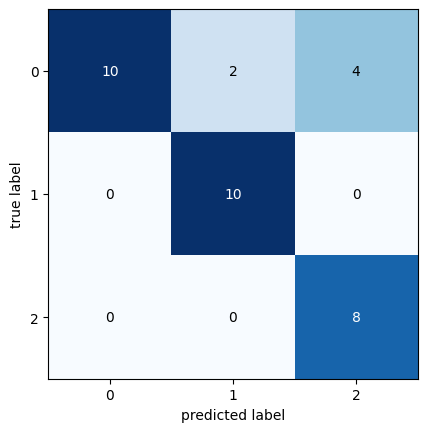

In [25]:
print(classification_report(y_test,y_pred))
matrix = confusion_matrix(y_test,y_pred)
fig,ax = plot_confusion_matrix(conf_mat=matrix)
plt.show()

# Adult

Prediction task is to determine whether a person makes over 50K a year. Fonte: https://archive.ics.uci.edu/ml/datasets/adult

In [84]:
adult_df = read_dataset('adult.csv',False)

In [12]:
adult_df = (
    adult_df.select(
        col('_c0').alias('age'),
        col('_c1').alias('workclass'),
        col('_c2').alias('fnlwgt'),
        col('_c3').alias('education'),
        col('_c4').alias('education-num'),
        col('_c5').alias('marital-status'),
        col('_c6').alias('occupation'),
        col('_c7').alias('relationship'),
        col('_c8').alias('race'),
        col('_c9').alias('sex'),
        col('_c10').alias('capital-gain'),
        col('_c11').alias('capital-loss'),
        col('_c12').alias('hours-per-week'),
        col('_c13').alias('native-country'),
        col('_c14').alias('label')
    )
)

In [13]:
adult_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- label: string (nullable = true)



In [14]:
adult_df.show()

+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
|age|       workclass|fnlwgt|   education|education-num|      marital-status|       occupation| relationship|              race|   sex|capital-gain|capital-loss|hours-per-week|native-country|label|
+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+-----+
| 39|       State-gov| 77516|   Bachelors|           13|       Never-married|     Adm-clerical|Not-in-family|             White|  Male|        2174|           0|            40| United-States|<=50K|
| 50|Self-emp-not-inc| 83311|   Bachelors|           13|  Married-civ-spouse|  Exec-managerial|      Husband|             White|  Male|           0|           0|            13| United-States|<=50K|
| 38|     

In [15]:
adult_df = adult_df.drop('fnlwgt')

In [16]:
adult_df.count()

32561

In [17]:
adult_df = adult_df.replace('?',None)

In [18]:
adult_df = adult_df.dropna(how='any')

In [19]:
adult_df.count()

30162

In [20]:
(trainingData,testData) = adult_df.randomSplit([0.8,0.2])

In [21]:
categoricalFeatures = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']

In [22]:
indexers = [StringIndexer(inputCol=column,outputCol=column + '_idx',handleInvalid='keep') for column in categoricalFeatures]

In [23]:
encoders = [OneHotEncoder(inputCol=column+'_idx',outputCol=column+'_enc') for column in categoricalFeatures]

In [24]:
labelIndexer = [StringIndexer(inputCol='label',outputCol='label_idx')]

In [25]:
requiredFeatures = [colunm + '_enc' for colunm in categoricalFeatures]

In [26]:
featureIndexer = VectorAssembler(inputCols=requiredFeatures,outputCol="features") 

In [28]:
rf = RandomForestClassifier(labelCol='label_idx', featuresCol='features', maxDepth=10)

In [29]:
pipeline = Pipeline(stages=indexers + encoders + labelIndexer + [featureIndexer,rf])

In [30]:
model = pipeline.fit(trainingData)

23/02/09 09:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1038.4 KiB


In [31]:
predictions = model.transform(testData)

In [32]:
predictions.select("prediction","label_idx","features").show()

+----------+---------+--------------------+
|prediction|label_idx|            features|
+----------+---------+--------------------+
|       0.0|      0.0|(98,[2,14,24,35,4...|
|       0.0|      0.0|(98,[2,12,24,35,4...|
|       0.0|      0.0|(98,[2,12,24,30,4...|
|       0.0|      0.0|(98,[2,12,24,34,4...|
|       0.0|      0.0|(98,[2,17,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,38,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,35,4...|
|       0.0|      0.0|(98,[0,14,24,34,4...|
|       0.0|      0.0|(98,[0,14,24,34,4...|
|       0.0|      0.0|(98,[0,14,24,34,4...|
|       0.0|      0.0|(98,[0,14,

In [33]:
evaluator = MulticlassClassificationEvaluator(labelCol="label_idx", predictionCol="prediction", metricName="f1")
fmeasure = evaluator.evaluate(predictions)
print("f1:",fmeasure)

f1: 0.8135320353114215


In [34]:
evaluator = MulticlassClassificationEvaluator(labelCol="label_idx", predictionCol="prediction", metricName="accuracy")
fmeasure = evaluator.evaluate(predictions)
print("accuracy:",fmeasure)

accuracy: 0.8254931714719271


In [35]:
y_pred = predictions.select(["prediction"]).collect()
y_test = predictions.select(["label_idx"]).collect()

              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89      4472
         1.0       0.71      0.49      0.58      1459

    accuracy                           0.83      5931
   macro avg       0.78      0.71      0.73      5931
weighted avg       0.81      0.83      0.81      5931



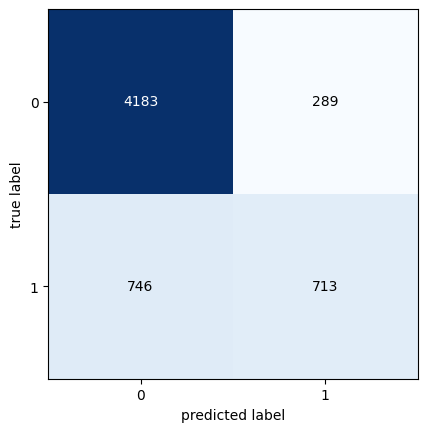

In [36]:
print(classification_report(y_test,y_pred))
matrix = confusion_matrix(y_test,y_pred)
fig,ax = plot_confusion_matrix(conf_mat=matrix)
plt.show()

# Automobile

Predicting the price of an automobile given a set of features

In [85]:
auto_df = read_dataset('imports-85.data',True)

In [86]:
auto_df.show()

+---------+-----------------+-----------+---------+----------+------------+-----------+------------+---------------+----------+------+-----+------+-----------+-----------+----------------+-----------+-----------+----+------+-----------------+----------+--------+--------+-----------+-----+
|symboling|normalized-losses|       make|fuel-type|aspiration|num-of-doors| body-style|drive-wheels|engine-location|wheel-base|length|width|height|curb-weight|engine-type|num-of-cylinders|engine-size|fuel-system|bore|stroke|compression-ratio|horsepower|peak-rpm|city-mpg|highway-mpg|price|
+---------+-----------------+-----------+---------+----------+------------+-----------+------------+---------------+----------+------+-----+------+-----------+-----------+----------------+-----------+-----------+----+------+-----------------+----------+--------+--------+-----------+-----+
|        3|                ?|alfa-romero|      gas|       std|         two|convertible|         rwd|          front|      88.6| 16

In [40]:
auto_df.printSchema()

root
 |-- symboling: integer (nullable = true)
 |-- normalized-losses: string (nullable = true)
 |-- make: string (nullable = true)
 |-- fuel-type: string (nullable = true)
 |-- aspiration: string (nullable = true)
 |-- num-of-doors: string (nullable = true)
 |-- body-style: string (nullable = true)
 |-- drive-wheels: string (nullable = true)
 |-- engine-location: string (nullable = true)
 |-- wheel-base: double (nullable = true)
 |-- length: double (nullable = true)
 |-- width: double (nullable = true)
 |-- height: double (nullable = true)
 |-- curb-weight: integer (nullable = true)
 |-- engine-type: string (nullable = true)
 |-- num-of-cylinders: string (nullable = true)
 |-- engine-size: integer (nullable = true)
 |-- fuel-system: string (nullable = true)
 |-- bore: string (nullable = true)
 |-- stroke: string (nullable = true)
 |-- compression-ratio: double (nullable = true)
 |-- horsepower: string (nullable = true)
 |-- peak-rpm: string (nullable = true)
 |-- city-mpg: integer (nu

In [41]:
auto_df = auto_df.replace('?',None)

In [42]:
auto_df = auto_df.dropna(how='any')

In [43]:
auto_df = auto_df.select(
    col('price').cast('float'),
    col('make'),
    col('num-of-doors'),
    col('body-style'),
    col('drive-wheels'),
    col('wheel-base').cast('float'),
    col('curb-weight').cast('float'),
    col('num-of-cylinders'),
    col('engine-size').cast('float'),
    col('horsepower').cast('float'),
    col('peak-rpm').cast('float'),
)

In [44]:
(trainingData,testData) = auto_df.randomSplit([0.8,0.2])

In [45]:
categoricalFeatures = ['make','num-of-doors','body-style','drive-wheels','num-of-cylinders']

In [46]:
indexers = [StringIndexer(inputCol=column,outputCol=column + '_idx',handleInvalid='keep') for column in categoricalFeatures]

In [47]:
encoders = [OneHotEncoder(inputCol=column+'_idx',outputCol=column+'_enc') for column in categoricalFeatures]

In [48]:
requiredFeatures = [colunm + '_enc' for colunm in categoricalFeatures] + ['wheel-base','curb-weight','engine-size','horsepower','peak-rpm']

In [49]:
featureassembler = VectorAssembler(inputCols=requiredFeatures,outputCol="features") 

In [51]:
lr = LinearRegression(maxIter=100,regParam=1.0,elasticNetParam=0.8,labelCol='price',featuresCol='features')

In [52]:
pipeline = Pipeline(stages=indexers + encoders + [featureassembler,lr])

In [53]:
model = pipeline.fit(trainingData)

23/02/09 09:33:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/02/09 09:33:06 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [54]:
lrModel = model.stages[-1]

In [55]:
print('R²:',lrModel.summary.r2)
print('RMSE:',lrModel.summary.rootMeanSquaredError)

R²: 0.9634354539502223
RMSE: 1141.5595888239434


In [56]:
lrModel.numFeatures

38

In [57]:
lrModel.coefficients

DenseVector([-1855.3049, 373.9966, 729.9236, -1447.3367, -1292.3642, -238.9051, -673.6731, -473.7332, 12.3754, -2103.3262, 6882.5368, -1134.4289, 1586.3466, 3168.5042, 4821.827, -523.639, 9866.1023, 7889.0257, 177.1779, -177.1779, -0.5837, 279.8665, -1213.8614, -467.3149, 4545.1351, -790.2627, 889.5831, -661.9102, -1047.111, 106.746, 1177.9866, 6505.1767, 252.7589, 173.0033, 5.1773, -51.7458, 57.2839, -1.068])

In [58]:
predictions = model.transform(testData)

In [59]:
predictions.select("prediction","price","features").show()

+------------------+-------+--------------------+
|        prediction|  price|            features|
+------------------+-------+--------------------+
|6192.7447313466055| 6229.0|(38,[11,18,21,25,...|
|6327.4638950497265| 6295.0|(38,[15,19,21,25,...|
| 7383.721256327657| 6529.0|(38,[2,19,21,25,2...|
| 7072.383127582454| 6695.0|(38,[5,18,20,25,2...|
| 6575.855855503263| 6938.0|(38,[0,18,20,25,2...|
| 7402.426877917138| 7463.0|(38,[4,18,22,25,2...|
| 6658.042223858671| 7609.0|(38,[11,18,20,25,...|
| 6758.184369123666| 7788.0|(38,[0,18,21,25,2...|
|  9255.62957331833| 7895.0|(38,[2,19,21,25,2...|
| 6477.734250263131| 7898.0|(38,[0,18,20,25,2...|
| 7068.575117916915| 8358.0|(38,[0,18,21,25,2...|
|10189.891372066328| 9549.0|(38,[1,18,20,25,2...|
| 11233.49399099856| 9989.0|(38,[0,19,21,26,2...|
| 10350.08124710019|11245.0|(38,[5,18,21,25,2...|
|11544.295465390327|11259.0|(38,[4,18,20,27,2...|
| 14139.70326580374|11850.0|(38,[12,19,21,25,...|
|15815.868448743504|13499.0|(38,[1,18,20,25,2...|


In [61]:
evaluator = RegressionEvaluator(labelCol='price',predictionCol='prediction',metricName='r2')
r2 = evaluator.evaluate(predictions)
print('Test R² score:', r2)

Test R² score: 0.9156474550234693


In [62]:
evaluator = RegressionEvaluator(labelCol='price',predictionCol='prediction',metricName='rmse')
rmse = evaluator.evaluate(predictions)
print('Test rmse score:', rmse)

Test rmse score: 1514.3197710850986


In [63]:
predict_df = predictions.select("prediction","price").toPandas()

/home/dataeng/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


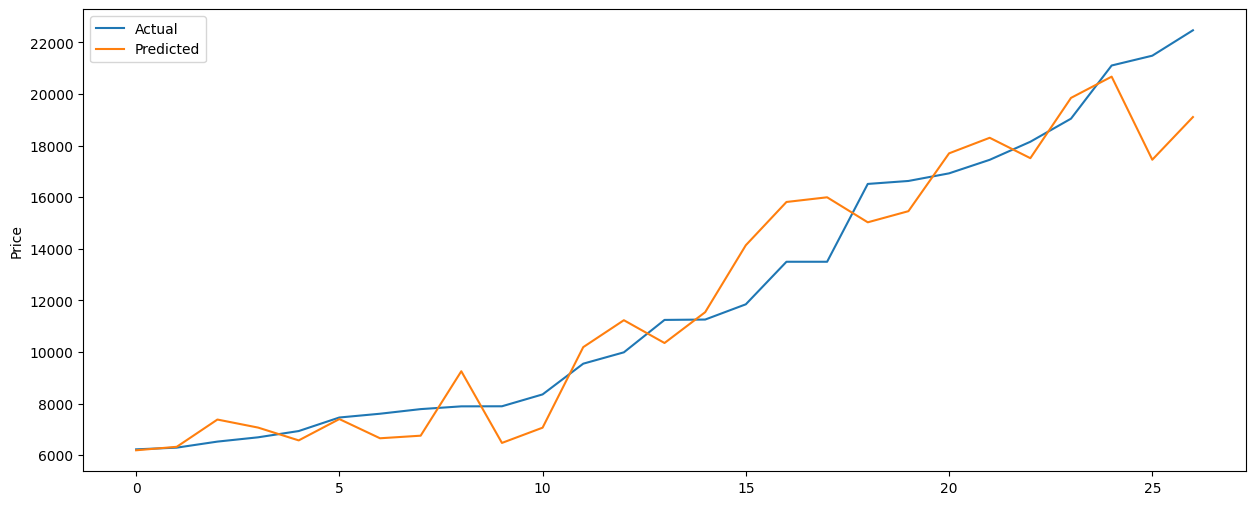

In [64]:
plt.figure(figsize=(15,6))
plt.plot(predict_df['price'],label='Actual')
plt.plot(predict_df['prediction'],label='Predicted')
plt.ylabel('Price')
plt.legend()
plt.show()

In [66]:
paramGrid = ParamGridBuilder().addGrid(
    lr.maxIter,[10,50,100]).addGrid(
    lr.regParam,[0.1,0.3,1.0]).addGrid(
    lr.elasticNetParam,[0.0,0.8,1.0]).build()

In [67]:
evaluator = RegressionEvaluator(labelCol='price',predictionCol='prediction',metricName='rmse')

In [69]:
crossval = CrossValidator(estimator=pipeline,estimatorParamMaps=paramGrid,evaluator=evaluator,numFolds=3)

In [70]:
model = crossval.fit(trainingData)

23/02/09 09:35:14 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [71]:
blrmodel = model.bestModel.stages[-1]

In [72]:
print('MaxIter', lrModel._java_obj.getMaxIter())
print('elasticNetParam',lrModel._java_obj.getElasticNetParam())
print('regParam',lrModel._java_obj.getRegParam())

MaxIter 100
elasticNetParam 0.8
regParam 1.0


In [73]:
predictions = model.transform(testData)

In [74]:
evaluator = RegressionEvaluator(labelCol='price',predictionCol='prediction',metricName='r2')
r2 = evaluator.evaluate(predictions)
print('Test R² score:', r2)

Test R² score: 0.8851161161731578


In [75]:
evaluator = RegressionEvaluator(labelCol='price',predictionCol='prediction',metricName='rmse')
rmse = evaluator.evaluate(predictions)
print('Test rmse score:', rmse)

Test rmse score: 1767.2502513137224


# Titanic

In [87]:
titanic_df = read_dataset('titanic.csv',True)

In [88]:
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [89]:
titanic_df = titanic_df.drop('PassengerId','Name','SibSp','Ticket','Cabin')

In [90]:
titanic_df = titanic_df.replace('?',None).dropna(how='any')

In [91]:
titanic_df = StringIndexer(inputCol='Sex',outputCol='Gender',handleInvalid='keep').fit(titanic_df).transform(titanic_df)

In [92]:
titanic_df = StringIndexer(inputCol='Embarked',outputCol='Boarded',handleInvalid='keep').fit(titanic_df).transform(titanic_df)

In [93]:
titanic_df = titanic_df.drop('Sex','Embarked')

In [94]:
assembler = VectorAssembler(inputCols=titanic_df.columns,outputCol='features')

In [95]:
titanic_ready = assembler.transform(titanic_df)

In [99]:
kmeans = KMeans(k=8, seed=3)
model = kmeans.fit(titanic_ready)

In [100]:
clusterdata = model.transform(titanic_ready)

In [101]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clusterdata)
print(silhouette)

0.6315918449619775


In [102]:
centers = model.clusterCenters()
centers

[array([ 0.23913043,  2.17391304, 51.47282609,  0.11956522, 16.22165   ,
         0.20652174,  0.20652174]),
 array([ 0.26470588,  2.76143791, 25.29411765,  0.10457516,  9.62966928,
         0.27124183,  0.21895425]),
 array([1.00000000e+00, 1.00000000e+00, 3.53333333e+01, 3.33333333e-01,
        5.12329200e+02, 3.33333333e-01, 1.00000000e+00]),
 array([  0.73333333,   1.        ,  30.33333333,   1.33333333,
        239.99194   ,   0.73333333,   0.53333333]),
 array([  0.73333333,   1.        ,  32.43066667,   0.86666667,
        131.18388333,   0.63333333,   0.5       ]),
 array([ 0.68888889,  1.16666667, 36.03333333,  0.32222222, 69.30111333,
         0.48888889,  0.38888889]),
 array([ 0.54320988,  2.62962963,  7.17592593,  1.30864198, 27.04722099,
         0.49382716,  0.2345679 ]),
 array([ 0.45263158,  1.93684211, 34.43684211,  0.87368421, 28.13162211,
         0.44210526,  0.21052632])]

In [103]:
clusterdata.show()

+--------+------+----+-----+-------+------+-------+--------------------+----------+
|Survived|Pclass| Age|Parch|   Fare|Gender|Boarded|            features|prediction|
+--------+------+----+-----+-------+------+-------+--------------------+----------+
|       0|     3|22.0|    0|   7.25|   0.0|    0.0|(7,[1,2,4],[3.0,2...|         1|
|       1|     1|38.0|    0|71.2833|   1.0|    1.0|[1.0,1.0,38.0,0.0...|         5|
|       1|     3|26.0|    0|  7.925|   1.0|    0.0|[1.0,3.0,26.0,0.0...|         1|
|       1|     1|35.0|    0|   53.1|   1.0|    0.0|[1.0,1.0,35.0,0.0...|         5|
|       0|     3|35.0|    0|   8.05|   0.0|    0.0|(7,[1,2,4],[3.0,3...|         1|
|       0|     1|54.0|    0|51.8625|   0.0|    0.0|(7,[1,2,4],[1.0,5...|         5|
|       0|     3| 2.0|    1| 21.075|   0.0|    0.0|[0.0,3.0,2.0,1.0,...|         6|
|       1|     3|27.0|    2|11.1333|   1.0|    0.0|[1.0,3.0,27.0,2.0...|         1|
|       1|     2|14.0|    0|30.0708|   1.0|    1.0|[1.0,2.0,14.0,0.0...|    

In [105]:
titanic_df.select(
    avg('Survived'),avg('Pclass'),avg('Age'),avg('Fare'),avg('Gender'),avg('Boarded')
).show()

+------------------+-----------------+-----------------+-----------------+------------------+------------------+
|     avg(Survived)|      avg(Pclass)|         avg(Age)|        avg(Fare)|       avg(Gender)|      avg(Boarded)|
+------------------+-----------------+-----------------+-----------------+------------------+------------------+
|0.4044943820224719|2.240168539325843|29.64209269662921|34.56725140449432|0.3637640449438202|0.2612359550561798|
+------------------+-----------------+-----------------+-----------------+------------------+------------------+



In [106]:
clusterdata.groupBy('prediction').agg(avg('Survived'),avg('Pclass'),avg('Age'),avg('Fare'),avg('Gender'),avg('Boarded'),count('prediction')).orderBy('prediction').show()

+----------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+
|prediction|      avg(Survived)|       avg(Pclass)|          avg(Age)|         avg(Fare)|        avg(Gender)|       avg(Boarded)|count(prediction)|
+----------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+
|         0| 0.2391304347826087|2.1739130434782608| 51.47282608695652|          16.22165|0.20652173913043478|0.20652173913043478|               92|
|         1| 0.2647058823529412| 2.761437908496732|25.294117647058822| 9.629669281045755|0.27124183006535946|0.21895424836601307|              306|
|         2|                1.0|               1.0|35.333333333333336|          512.3292| 0.3333333333333333|                1.0|                3|
|         3| 0.7333333333333333|               1.0|30.333333333333332|239.99194000000003| 0.7333333333333333| 0.

In [107]:
clusterdata.filter(clusterdata.prediction==1).show()

+--------+------+----+-----+-------+------+-------+--------------------+----------+
|Survived|Pclass| Age|Parch|   Fare|Gender|Boarded|            features|prediction|
+--------+------+----+-----+-------+------+-------+--------------------+----------+
|       0|     3|22.0|    0|   7.25|   0.0|    0.0|(7,[1,2,4],[3.0,2...|         1|
|       1|     3|26.0|    0|  7.925|   1.0|    0.0|[1.0,3.0,26.0,0.0...|         1|
|       0|     3|35.0|    0|   8.05|   0.0|    0.0|(7,[1,2,4],[3.0,3...|         1|
|       1|     3|27.0|    2|11.1333|   1.0|    0.0|[1.0,3.0,27.0,2.0...|         1|
|       0|     3|20.0|    0|   8.05|   0.0|    0.0|(7,[1,2,4],[3.0,2...|         1|
|       0|     3|14.0|    0| 7.8542|   1.0|    0.0|[0.0,3.0,14.0,0.0...|         1|
|       0|     3|31.0|    0|   18.0|   1.0|    0.0|[0.0,3.0,31.0,0.0...|         1|
|       1|     2|34.0|    0|   13.0|   0.0|    0.0|[1.0,2.0,34.0,0.0...|         1|
|       1|     3|15.0|    0| 8.0292|   1.0|    2.0|[1.0,3.0,15.0,0.0...|    

# Day

In [110]:
day_df = read_dataset('day.csv',True)

In [111]:
day_df.printSchema()

root
 |-- instant: integer (nullable = true)
 |-- dteday: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)



In [112]:
day_df= day_df.drop('instant', 'dteday','casual','registered')

In [113]:
day_df.show()

+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+
|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed| cnt|
+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+
|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446| 985|
|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539| 801|
|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|1349|
|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|1562|
|     1|  0|   1|      0|      3|         1|         1|0.226957| 0.22927|0.436957|   0.1869|1600|
|     1|  0|   1|      0|      4|         1|         1|0.204348|0.233209|0.518261|0.0895652|1606|
|     1|  0|   1|      0|      5|         1|         2|0.196522|0.208839|0.498696| 0.168726|1510|
|     1|  0|   1|   

/home/dataeng/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


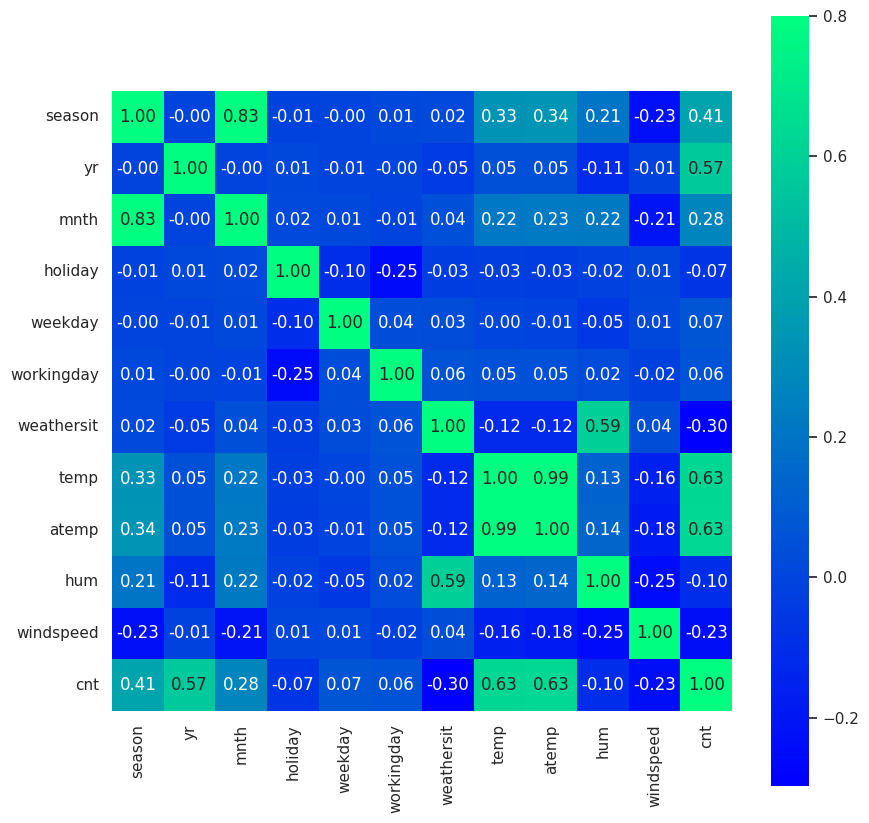

In [117]:
corrmat = day_df.toPandas().corr()
plt.figure(figsize=(10,10))
sns.set(font_scale=1.0)
sns.heatmap(corrmat,vmax=.8,square=True,annot=True, fmt='.2f',cmap = 'winter')
plt.show()

In [118]:
featureCols = day_df.columns.copy()

In [119]:
featureCols.remove('cnt')

In [120]:
featureCols

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [121]:
assembler = VectorAssembler(inputCols=featureCols,outputCol='features')

In [122]:
day_df_feat = assembler.transform(day_df)
day_df_feat.show()

+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+--------------------+
|season| yr|mnth|holiday|weekday|workingday|weathersit|    temp|   atemp|     hum|windspeed| cnt|            features|
+------+---+----+-------+-------+----------+----------+--------+--------+--------+---------+----+--------------------+
|     1|  0|   1|      0|      6|         0|         2|0.344167|0.363625|0.805833| 0.160446| 985|[1.0,0.0,1.0,0.0,...|
|     1|  0|   1|      0|      0|         0|         2|0.363478|0.353739|0.696087| 0.248539| 801|[1.0,0.0,1.0,0.0,...|
|     1|  0|   1|      0|      1|         1|         1|0.196364|0.189405|0.437273| 0.248309|1349|[1.0,0.0,1.0,0.0,...|
|     1|  0|   1|      0|      2|         1|         1|     0.2|0.212122|0.590435| 0.160296|1562|[1.0,0.0,1.0,0.0,...|
|     1|  0|   1|      0|      3|         1|         1|0.226957| 0.22927|0.436957|   0.1869|1600|[1.0,0.0,1.0,0.0,...|
|     1|  0|   1|      0|      4|         1|    

In [123]:
(trainingData,testData) = day_df_feat.randomSplit([0.8,0.2])

In [124]:
lr = LinearRegression(maxIter=100,regParam=1.0,elasticNetParam=0.8,labelCol='cnt',featuresCol='features')

In [125]:
model = lr.fit(trainingData)

In [126]:
predictions = model.transform(testData)

In [127]:
evaluator = RegressionEvaluator(labelCol='cnt',predictionCol='prediction',metricName='r2')
r2 = evaluator.evaluate(predictions)
print('Test R² score:', r2)

Test R² score: 0.7764823799116101


In [128]:
evaluator = RegressionEvaluator(labelCol='cnt',predictionCol='prediction',metricName='rmse')
rmse = evaluator.evaluate(predictions)
print('Test rmse score:', rmse)

Test rmse score: 953.1888188056358


In [129]:
predict_df = predictions.select("cnt","prediction").toPandas()

/home/dataeng/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


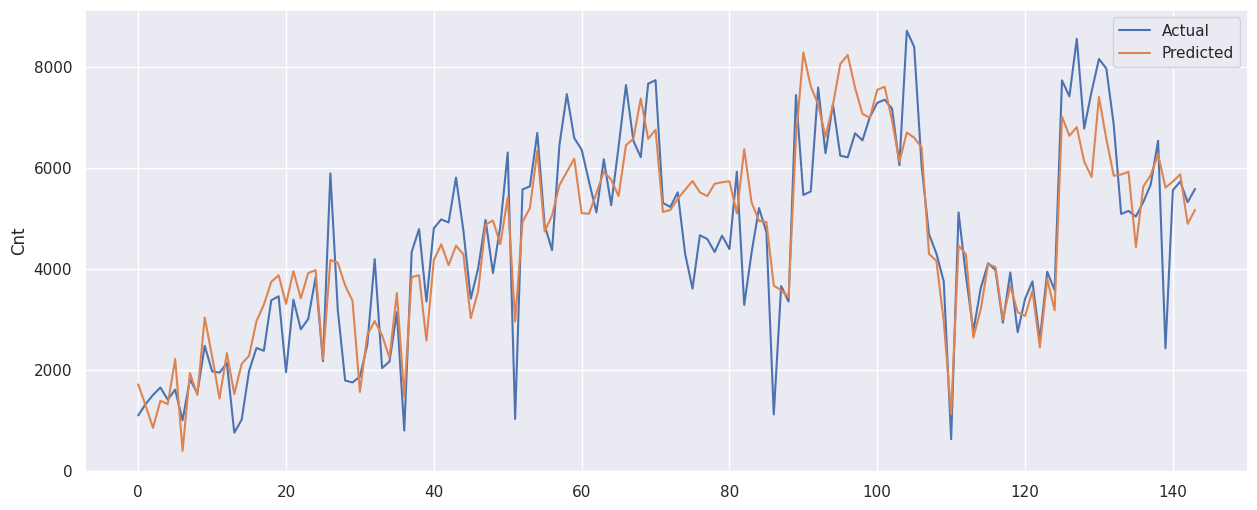

In [130]:
plt.figure(figsize=(15,6))
plt.plot(predict_df['cnt'],label='Actual')
plt.plot(predict_df['prediction'],label='Predicted')
plt.ylabel('Cnt')
plt.legend()
plt.show()

In [131]:
pca = PCA(k=8,inputCol='features',outputCol='pcaFeatures')

In [132]:
pcatranform = pca.fit(day_df_feat)

23/02/09 09:56:54 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/09 09:56:54 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [133]:
pcatranform.explainedVariance

DenseVector([0.7093, 0.2227, 0.0201, 0.0171, 0.0137, 0.0119, 0.0028, 0.0014])

In [134]:
pcafeature = pcatranform.transform(day_df_feat).select('pcaFeatures')
pcafeature.show()

+--------------------+
|         pcaFeatures|
+--------------------+
|[-1.2994341055128...|
|[-1.2560740466291...|
|[-1.2498374390477...|
|[-1.2589193779944...|
|[-1.2649515947305...|
|[-1.2729147964420...|
|[-1.2856192710391...|
|[-1.2921840792479...|
|[-1.2413300547201...|
|[-1.2493942400509...|
|[-1.2659441069314...|
|[-1.2644614872243...|
|[-1.2701427734999...|
|[-1.2789252699700...|
|[-1.2941105474080...|
|[-1.2449798149026...|
|[-1.2585149268013...|
|[-1.2684139693571...|
|[-1.2757020639233...|
|[-1.2801173209444...|
+--------------------+
only showing top 20 rows



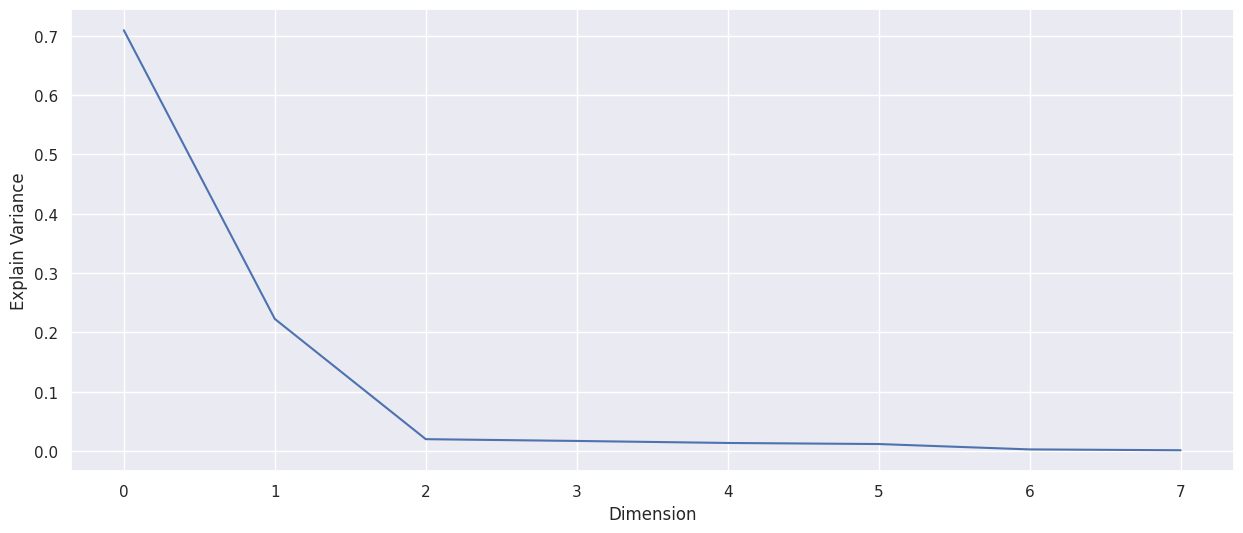

In [135]:
plt.figure(figsize=(15,6))
plt.plot(pcatranform.explainedVariance)
plt.xlabel('Dimension')
plt.ylabel('Explain Variance')
plt.show()

In [136]:
pcafeature = pcafeature.withColumn('row_index',monotonically_increasing_id())
day_df_feat = day_df_feat.withColumn('row_index',monotonically_increasing_id())

In [137]:
transformedData = pcafeature.join(day_df_feat,on=['row_index']).sort('row_index').select('cnt','pcaFeatures')
transformedData.show()

+----+--------------------+
| cnt|         pcaFeatures|
+----+--------------------+
| 985|[-1.2994341055128...|
| 801|[-1.2560740466291...|
|1349|[-1.2498374390477...|
|1562|[-1.2589193779944...|
|1600|[-1.2649515947305...|
|1606|[-1.2729147964420...|
|1510|[-1.2856192710391...|
| 959|[-1.2921840792479...|
| 822|[-1.2413300547201...|
|1321|[-1.2493942400509...|
|1263|[-1.2659441069314...|
|1162|[-1.2644614872243...|
|1406|[-1.2701427734999...|
|1421|[-1.2789252699700...|
|1248|[-1.2941105474080...|
|1204|[-1.2449798149026...|
|1000|[-1.2585149268013...|
| 683|[-1.2684139693571...|
|1650|[-1.2757020639233...|
|1927|[-1.2801173209444...|
+----+--------------------+
only showing top 20 rows



In [138]:
(pcatrainingData,pcatestData) = transformedData.randomSplit([0.8,0.2])

In [139]:
pcalr = LinearRegression(maxIter=100,regParam=1.0,elasticNetParam=0.8,labelCol='cnt',featuresCol='pcaFeatures')

In [140]:
model = pcalr.fit(pcatrainingData)

In [141]:
predictions = model.transform(pcatestData)

In [142]:
evaluator = RegressionEvaluator(labelCol='cnt',predictionCol='prediction',metricName='r2')
r2 = evaluator.evaluate(predictions)
print('Test R² score:', r2)

Test R² score: 0.7318523887566852


In [143]:
evaluator = RegressionEvaluator(labelCol='cnt',predictionCol='prediction',metricName='rmse')
rmse = evaluator.evaluate(predictions)
print('Test rmse score:', rmse)

Test rmse score: 967.3973824978364


# Movie

In [145]:
ratings_df = read_dataset('ratings.csv',True)

In [146]:
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [147]:
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [148]:
ratings_df = ratings_df.drop('timestamp')

In [149]:
ratings_df.select('rating').toPandas().describe()

/home/dataeng/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,rating
count,100004.000000
mean,3.543608
std,1.058064
min,0.500000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [150]:
(trainingData,testData) = ratings_df.randomSplit([0.8,0.2])

In [152]:
als = ALS(maxIter=5,regParam=0.1,userCol='userId',itemCol='movieId',ratingCol='rating',coldStartStrategy='drop')

In [153]:
model = als.fit(trainingData)

In [154]:
predictions = model.transform(testData)
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|     29|   3.5|  4.121434|
|   148|     32|   4.0|   4.15033|
|   148|     40|   4.5| 3.6842566|
|   148|    934|   3.5| 4.0286508|
|   148|   1136|   4.5|  4.682229|
|   148|   1172|   5.0|  4.427302|
|   148|   1252|   5.0|  4.454056|
|   148|   1261|   3.0| 4.1708927|
|   148|   1394|   4.5|  4.170761|
|   148|   1449|   4.5|  4.424697|
|   148|   1584|   3.5|  3.892128|
|   148|   1625|   4.0| 3.9431486|
|   148|   1690|   3.0| 3.1088336|
|   148|   1711|   4.0| 3.3545818|
|   148|   1779|   3.5| 3.1682568|
|   148|   2046|   4.5| 3.8010805|
|   148|   2174|   4.0| 3.8675487|
|   148|   2571|   4.5| 4.4156723|
|   148|   2706|   1.0| 3.5682223|
|   148|   3175|   4.0| 3.9647756|
+------+-------+------+----------+
only showing top 20 rows



In [155]:
predictions.select('rating','prediction').toPandas().describe()

/home/dataeng/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,rating,prediction
count,19336.000000,19336.000000
mean,3.562267,3.389869
std,1.044387,0.752836
min,0.500000,0.038826
25%,3.000000,2.947011
50%,4.000000,3.473314
75%,4.000000,3.919980
max,5.000000,5.636985


In [156]:
evaluator = RegressionEvaluator(metricName='rmse',labelCol='rating',predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
rmse

0.9171292702495608

In [157]:
userRecsAll = model.recommendForAllUsers(3)
userRecsAll.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{53123, 4.135737...|
|     2|[{6413, 4.9434114...|
|     3|[{67504, 4.93946}...|
|     4|[{67504, 6.34247}...|
|     5|[{59684, 5.084768...|
|     6|[{940, 5.122101},...|
|     7|[{67504, 5.282695...|
|     8|[{67504, 5.040885...|
|     9|[{67504, 5.798464...|
|    10|[{67504, 5.337259...|
|    11|[{8607, 5.5227685...|
|    12|[{3879, 4.972213}...|
|    13|[{67504, 4.882725...|
|    14|[{5765, 4.977227}...|
|    15|[{4731, 5.0522113...|
|    16|[{40412, 5.537408...|
|    17|[{2066, 5.1760716...|
|    18|[{4967, 4.9207067...|
|    19|[{67504, 5.506343...|
|    20|[{3914, 5.283403}...|
+------+--------------------+
only showing top 20 rows



In [158]:
movieRecsAll = model.recommendForAllItems(3)
movieRecsAll.show()

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|     26|[{113, 5.2716236}...|
|     27|[{46, 4.117227}, ...|
|     28|[{113, 5.381719},...|
|     31|[{46, 4.4083624},...|
|     34|[{113, 5.3058653}...|
|     44|[{113, 3.9722939}...|
|     53|[{517, 5.6639814}...|
|     65|[{477, 4.3593903}...|
|     76|[{51, 4.4637713},...|
|     78|[{156, 4.0558076}...|
|     81|[{348, 4.658925},...|
|     85|[{70, 5.29083}, {...|
|    101|[{181, 4.9536}, {...|
|    103|[{113, 5.449358},...|
|    108|[{564, 4.0357323}...|
|    126|[{366, 4.3972406}...|
|    137|[{564, 1.0089331}...|
|    148|[{153, 4.2178574}...|
|    155|[{46, 5.4605303},...|
|    159|[{46, 5.2889934},...|
+-------+--------------------+
only showing top 20 rows



In [161]:
userList = [148,463,267]
usersDF = spark.createDataFrame(userList,IntegerType()).toDF('userId')
usersDF.show()

+------+
|userId|
+------+
|   148|
|   463|
|   267|
+------+



In [162]:
userRecs = model.recommendForUserSubset(usersDF,5)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[{83411, 5.619459...|
|   463|[{83411, 5.212364...|
|   267|[{65188, 5.306656...|
+------+--------------------+



In [163]:
userMovieList = userRecs.filter(userRecs.userId == 148).select('recommendations')
userMovieList.show()

+--------------------+
|     recommendations|
+--------------------+
|[{83411, 5.619459...|
+--------------------+



In [164]:
movieList = userMovieList.collect()[0].recommendations
movieList

[Row(movieId=83411, rating=5.61945915222168),
 Row(movieId=67504, rating=5.61945915222168),
 Row(movieId=83359, rating=5.61945915222168),
 Row(movieId=54328, rating=5.147768497467041),
 Row(movieId=6918, rating=5.132166862487793)]

In [165]:
moviesDF = spark.createDataFrame(movieList)
moviesDF.show()

+-------+-----------------+
|movieId|           rating|
+-------+-----------------+
|  83411| 5.61945915222168|
|  67504| 5.61945915222168|
|  83359| 5.61945915222168|
|  54328|5.147768497467041|
|   6918|5.132166862487793|
+-------+-----------------+



In [166]:
movie_df = read_dataset('movies.csv',True)

In [167]:
recommmendedMovies = movie_df.join(moviesDF, on=['movieID']).orderBy('rating',ascending=False).select('title','genres','rating')
recommmendedMovies.show()

+--------------------+-----------+-----------------+
|               title|     genres|           rating|
+--------------------+-----------+-----------------+
|         Cops (1922)|     Comedy| 5.61945915222168|
|Land of Silence a...|Documentary| 5.61945915222168|
|Play House, The (...|     Comedy| 5.61945915222168|
|My Best Friend (M...|     Comedy|5.147768497467041|
|Unvanquished, The...|      Drama|5.132166862487793|
+--------------------+-----------+-----------------+



In [168]:
def getRecommendationsForUser(userId,numRecs):
  usersDF = spark.createDataFrame([userId],IntegerType()).toDF('userId')
  userRecs = model.recommendForUserSubset(usersDF,numRecs)
  movieList = userMovieList.collect()[0].recommendations
  moviesDF = spark.createDataFrame(movieList)
  recommmendedMovies = movie_df.join(moviesDF, on=['movieID']).orderBy('rating',ascending=False).select('title','genres','rating')
  return recommmendedMovies

In [169]:
getRecommendationsForUser(4,2).show()

+--------------------+-----------+-----------------+
|               title|     genres|           rating|
+--------------------+-----------+-----------------+
|Play House, The (...|     Comedy| 5.61945915222168|
|Land of Silence a...|Documentary| 5.61945915222168|
|         Cops (1922)|     Comedy| 5.61945915222168|
|My Best Friend (M...|     Comedy|5.147768497467041|
|Unvanquished, The...|      Drama|5.132166862487793|
+--------------------+-----------+-----------------+

